In [1]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import networkx as nx
import numpy as np
import pandas as pd
from discreteMarkovChain import markovChain
import os
import glob
import random
from scipy.stats import expon
from smart_open import open
from xml.dom.minidom import parse, Node

In [2]:
all_chars = ['Start/End',"DUKE OF VENICE",
"BRABANTIO",
"First Senator",
"Second Senator",
"GRATIANO",
"LODOVICO",
"OTHELLO",
"CASSIO",
"IAGO",
"RODERIGO",
"MONTANO",
"Clown",
"DESDEMONA",
"EMILIA","All", 'First Musician',
"BIANCA", "Senator", "First Gentleman", 'Second Gentleman', "Third Gentleman", 'Fourth Gentleman','Second Gentlemen', 'Sailor',
"Sailor", "Messenger", "Herald", "First Officer", "Second Officer","Gentleman", "Musicians", "Attendants"]

len(all_chars)

c = 0
cd = np.zeros((15,33))
xmlTree = parse(open("othello.xml"))
for nodes in xmlTree.getElementsByTagName("SCENE"):
  order_of_speech = []
  scene = nodes.getElementsByTagName("TITLE")[0].childNodes[0].data
  for node in nodes.getElementsByTagName("SPEECH"):
      for i in range(len(node.getElementsByTagName("SPEAKER"))):
          line = node.getElementsByTagName("SPEAKER")[i].firstChild.data
          order_of_speech.append(line)
  d = {x:order_of_speech.count(x) for x in order_of_speech}
  #chars = ["Beginning"]
  chars = ["Start/End"]
  chars += list(d.keys())
  P = np.zeros((len(chars),len(chars)))
  prev = chars.index(order_of_speech[0])
  for s in order_of_speech[1:]:
    current = chars.index(s)
    P[prev][current] += 1
    prev = current
  P[prev][chars.index("Start/End")] += 1
  P[chars.index("Start/End")][chars.index(order_of_speech[0])] += 1
  mapping = {}
  for i,v in enumerate(chars):
      mapping[i]=v
  P /=  P.sum(axis=1)[:,np.newaxis]
  mc = markovChain(P)
  mc.computePi('eigen')
  print("###",scene.split("/")[-1].replace(".htm",""))
  for i in range(len(chars)):
      print("%.4f # %s" % (mc.pi[i],mapping[i]))
      cd[c,all_chars.index(mapping[i])] = mc.pi[i]
  c += 1
  G = nx.DiGraph()
  for n in all_chars:
    G.add_node(n)
  labels={}
  edge_labels={}
  for i, origin_state in enumerate(chars):
      for j, destination_state in enumerate(chars):
          rate = P[i][j]
          if rate > 0:
              G.add_edge(origin_state,
                        destination_state,
                        weight=rate,
                        label="{:.02f}".format(rate))
              edge_labels[(origin_state, destination_state)] = label="{:.02f}".format(rate)

### SCENE I.  Venice. A street.
0.0217 # Start/End
0.3696 # RODERIGO
0.2826 # IAGO
0.3261 # BRABANTIO
### SCENE II.  Another street.
0.0303 # Start/End
0.2727 # IAGO
0.3333 # OTHELLO
0.1818 # CASSIO
0.0303 # RODERIGO
0.1212 # BRABANTIO
0.0303 # First Officer
### SCENE III.  A council-chamber.
0.0112 # Start/End
0.2809 # DUKE OF VENICE
0.0899 # First Senator
0.0112 # Second Senator
0.0225 # Sailor
0.0225 # First Officer
0.0225 # Messenger
0.1236 # BRABANTIO
0.0225 # Senator
0.1124 # OTHELLO
0.0337 # DESDEMONA
0.1236 # RODERIGO
0.1236 # IAGO
### SCENE I.  A Sea-port in Cyprus. An open place near the quay.
0.0116 # Start/End
0.1047 # MONTANO
0.0116 # First Gentleman
0.0465 # Second Gentleman
0.0465 # Third Gentleman
0.1628 # CASSIO
0.0116 # Fourth Gentleman
0.0116 # Second Gentlemen
0.1860 # DESDEMONA
0.2558 # IAGO
0.0349 # EMILIA
0.0465 # OTHELLO
0.0698 # RODERIGO
### SCENE II.  A street.
0.5000 # Start/End
0.5000 # Herald
### SCENE III.  A hall in the castle.
0.0100 # Start/End
0.1000 #

/opt/anaconda3/lib/python3.7/site-packages/discreteMarkovChain/markovChain.py:441: UserWarning: eigenMethod() does not work for a Markov chain with two states, calling powerMethod() instead.
  warn("eigenMethod() does not work for a Markov chain with two states, calling powerMethod() instead.")


In [3]:
number = 10000
alphas = []
kwargs = dict(alpha=0.5, bins=100, density=True)
np.random.seed(int.from_bytes(os.urandom(4), byteorder='little')) 
#fig = plt.figure(figsize=(22.5,5))
for i in range(15):
    avg = []
    for k in range(number):
        char_order = []
        for t in range(500):
            random_character = all_chars[np.random.choice(33, 1, p=cd[i,:])[0]]
            char_order.append(random_character)
            if random_character == "Start/End":
                break
        avg.append(len(char_order))
    avg.sort(reverse=True)
    #ax = fig.add_subplot(1,28,i+1)
    #ax.hist(avg, **kwargs, color=np.random.rand(3,))
    #ax.set_title(labels[i])
    loc, scale = expon.fit(avg, floc=0)
    print(loc, scale)
    #x = np.linspace(0,max(avg),1000)
    #y = expon.pdf(x, loc, scale)
    #ax.plot(x, y)
    alphas.append(scale)

0.0 46.0196
0.0 33.0858
0.0 88.986
0.0 86.1367
0.0 2.0235
0.0 99.5306
0.0 26.4412
0.0 5.0362
0.0 158.3241
0.0 94.4119
0.0 141.3306
0.0 103.6302
0.0 43.4454
0.0 80.1154
0.0 168.3147


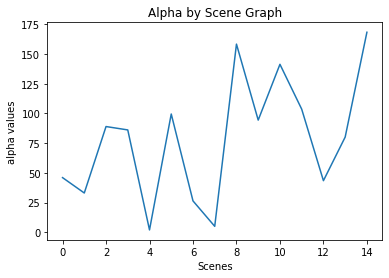

In [4]:
plt.plot(range(15),alphas)
plt.xlabel('Scenes')
plt.ylabel('alpha values')
plt.title('Alpha by Scene Graph')
plt.savefig('figures/macbeth_alpha.png')